Implementation of REBAR (https://arxiv.org/abs/1703.07370), a low-variance, unbiased gradient estimator for discrete latent variable models. This notebook is focused solely on the toy problem from Section 5.1 to help illuminate how REBAR works. The objective of the toy problem is to estimate the parameter for a single Bernoulli random variable. 

Recall that the problem being solved is $\text{max} \hspace{5px} \mathbb{E} [f(b, \theta) | p(b) ]$, $b$ ~ Bernoulli($\theta$).

For the toy problem, we want to estimate $\theta$ that minimizes the mean square error $ \mathbb{E} [(b - t)^2 \hspace{5px}|\hspace{5px} p(b) ]$, where $t = 0.45$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad
import matplotlib.pyplot as plt

%matplotlib inline

Lets first create our simple model. It's just a single number $\theta$, $0 < \theta < 1$, whose value we want to estimate. 

In [2]:
class SimpleBernoulli(nn.Module):
    def __init__(self, init_value=0.5):
        super(SimpleBernoulli, self).__init__()
        self.theta = nn.Parameter(torch.FloatTensor([init_value]))
  
    def forward(self):
        return F.sigmoid(self.theta)

Now, the REBAR gradient estimator is a single-sample Monte-Carlo estimate that attempts to remove the bias introduced by a continuous relaxation of the discrete latent variable. It does this by combining gradients from the continuous relaxation (a.k.a. the Concrete relaxation (https://arxiv.org/abs/1611.00712)), with REINFORCE gradients. I won't go into the details of REBAR's derivation (see Section 3 of the paper), but I will break down the components of the REBAR estimator and explain the control variates as clearly as possible. Please let me know if you notice that I misinterpreted anything or made any errors (this is a fairly challenging paper for non-statisticians!)

First, let's carefully implement some utility functions. 

In [3]:
def binary_log_likelihood(y, log_y_hat):
    # standard LL for vectors of binary labels y and log predictions log_y_hat
    return (y * -F.softplus(-log_y_hat)) + (1 - y) * (-log_y_hat - F.softplus(-log_y_hat))

def H(x):
    # Heaviside function, 0 if x < 0 else 1
    return torch.div(F.threshold(x, 0, 0), x)
    
def reparam_pz(u, theta):
    # From Appendix C of the paper, this is the reparameterization of p(z). 
    # Returns z, a Gumbel RV.
    return (torch.log(theta) - torch.log(1 - theta)) + (torch.log(u) - torch.log(1 - u))

def reparam_pz_b(v, b, theta):
    # From Appendix C of the paper, this is the reparameterization of p(z|b) for the 
    # case where b ~ Bernoulli($\theta$). Returns z_squiggle, a Gumbel RV
    return(b * F.softplus(torch.log(v) - torch.log((1 - v) * (1 - theta)))) \
        + ((1 - b) * (-F.softplus(torch.log(v) - torch.log(v * (1 - theta)))))

One of the main concepts to understand is the fact that the Concrete relaxation is applied to the discrete RV b ~ Bernoulli($\theta$), s.t. b = H(z) where H is the heaviside function and z ~ Gumbel.

Now, we can initialize a few things.

In [4]:
random_seed = 1337
torch.manual_seed(random_seed)
# hyperparams
rebar_eta_z = 0.1
rebar_eta_zb = 0.1
rebar_lamda=0.5
concrete_lamda = 0.5
batch_size = 128
train_steps = 8000

# Initialize three models to compare the REINFORCE, Concrete(0.5), and REBAR estimators
reinforce = SimpleBernoulli()
concrete = SimpleBernoulli()
rebar = SimpleBernoulli()
reinforce_opt = optim.Adam(reinforce.parameters(), lr=1e-3)
concrete_opt = optim.Adam(concrete.parameters(), lr=1e-3)
rebar_opt = optim.Adam(rebar.parameters(), lr=1e-3)
mse = nn.MSELoss()
# labels
targets = Variable(torch.FloatTensor([0.45]).repeat(batch_size), requires_grad=False)

Now for the main training loop, where most of the REBAR magic happens:

In [5]:
reinforce_loss = []
concrete_loss = []
rebar_loss = []
for i in range(train_steps):
    # For each iteration of the loop, we will compute a
    # single-sample MC estimate of the gradient
    # Get the latest estimate of $\theta$ copy it to form a minibatch
    reinforce_theta = reinforce.forward().repeat(batch_size)
    concrete_theta = concrete.forward().repeat(batch_size)
    rebar_theta = rebar.forward().repeat(batch_size)
    
    # sample batch_size pairs of Unif(0,1). You're supposed to couple u,v
    # to do the reparameterizations, but we omit that for this toy problem
    uv = Variable(torch.FloatTensor(2, batch_size).uniform_(0, 1), requires_grad=False)
    u = uv[0] + 1e-9 # for numerical stability
    v = uv[1] + 1e-9 # for numerical stability
    
    ########## First, we'll compute the REINFORCE estimator ##########
    
    # Lets record where the loss is at currently
    discrete_reinforce_preds = torch.bernoulli(reinforce_theta.detach())
    reinforce_loss.append(mse(discrete_reinforce_preds, targets).data.numpy())
    
    # Now, the REINFORCE estimator (Eq. 2 of the paper, beg. of Section 3)
    reinforce_z = reparam_pz(u, reinforce_theta)
    reinforce_Hz = H(reinforce_z) # this is the non-differentiable reparameterization
    # evaluate f
    reinforce_f_Hz = (reinforce_Hz - targets) ** 2
    # This is  d_log_P(b) / d_$\theta$
    grad_logP = grad(binary_log_likelihood(reinforce_Hz, \
                     torch.log(reinforce_theta)).split(1), reinforce_theta)[0]
    
    # Apply the Monte-carlo REINFORCE gradient estimator
    reinforce_grad_est = (reinforce_f_Hz * grad_logP).mean().view(1)
    reinforce_opt.grad = None
    reinforce.theta.grad = reinforce_grad_est
    reinforce_opt.step()
    
    ########## Next up, the Concrete(0.5) estimator ##########
    
    discrete_concrete_preds = torch.bernoulli(concrete_theta.detach())
    concrete_loss.append(mse(discrete_concrete_preds, targets).data.numpy())

    # Now, the Concrete(0.5) estimator. We compute the continuous relaxation of
    # the reparameterization and use that.. (end of Section 2 of the paper)
    concrete_z = reparam_pz(u, concrete_theta)
    soft_concrete_z = F.sigmoid(concrete_z / concrete_lamda) + 1e-9
    # evaluate f
    f_soft_concrete_z = (soft_concrete_z - targets) ** 2
    grad_f = grad(f_soft_concrete_z.split(1), concrete_theta)[0]

    # Apply the Monte-carlo Concrete gradient estimator
    concrete_grad_est = grad_f.mean().view(1)
    concrete_opt.grad = None
    concrete.theta.grad = concrete_grad_est
    concrete_opt.step()
    
    ########## Finally, we tie it all together with REBAR ##########
    
    discrete_rebar_preds = torch.bernoulli(rebar_theta.detach())
    rebar_loss.append(mse(discrete_rebar_preds, targets).data.numpy())

    # We compute the continuous relaxation of the reparameterization 
    # as well as the REINFORCE estimator and combine them.

    rebar_z = reparam_pz(u, rebar_theta)
    # "hard" bc this is non-differentiable
    hard_concrete_rebar_z = H(rebar_z)
    # We also need to compute the reparam for p(z|b) - see the paper
    # for explanation of this conditional marginalization as control variate
    rebar_zb = reparam_pz_b(v, hard_concrete_rebar_z, rebar_theta)
    # "soft" relaxations
    soft_concrete_rebar_z = F.sigmoid(rebar_z / rebar_lamda) + 1e-9 
    soft_concrete_rebar_zb = F.sigmoid(rebar_zb / rebar_lamda) + 1e-9
    # evaluate f
    f_hard_concrete_rebar_z = (hard_concrete_rebar_z - targets) ** 2
    f_soft_concrete_rebar_z = (soft_concrete_rebar_z - targets) ** 2
    f_soft_concrete_rebar_zb = (soft_concrete_rebar_zb - targets) ** 2
    # compute the necessary derivatives
    grad_logP = grad(binary_log_likelihood(hard_concrete_rebar_z, \
                     torch.log(rebar_theta)).split(1), rebar_theta, retain_graph=True)[0]
    grad_sc_z = grad(f_soft_concrete_rebar_z.split(1), rebar_theta, retain_graph=True)[0]
    grad_sc_zb = grad(f_soft_concrete_rebar_zb.split(1), rebar_theta)[0]
    
    # Notice how we combine the REINFORCE and concrete estimators
    rebar_grad_est = ((((f_hard_concrete_rebar_z - rebar_eta_zb * f_soft_concrete_rebar_zb) \
                       * grad_logP) + rebar_eta_zb * grad_sc_z - rebar_eta_zb * grad_sc_zb).mean()).view(1)
    
    # Apply the Monte-carlo REBAR gradient estimator
    rebar_opt.grad = None
    rebar.theta.grad = rebar_grad_est
    rebar_opt.step()
    
    if (i+1) % 1000 == 0:
        print("step: {}".format(i+1))
        print("reinforce_loss {}".format(reinforce_loss[-1]))
        print("concrete(0.5)_loss {}".format(concrete_loss[-1]))
        print("rebar_loss {}\n".format(rebar_loss[-1]))

/nfs01/shared_software/anaconda3/envs/artem2/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


step: 1000
reinforce_loss 0.2407812476158142
concrete(0.5)_loss 0.24546875059604645
rebar_loss 0.24156250059604645

step: 2000
reinforce_loss 0.22828124463558197
concrete(0.5)_loss 0.2384375035762787
rebar_loss 0.22593750059604645

step: 3000
reinforce_loss 0.21031248569488525
concrete(0.5)_loss 0.23765625059604645
rebar_loss 0.21421873569488525

step: 4000
reinforce_loss 0.20874999463558197
concrete(0.5)_loss 0.24156250059604645
rebar_loss 0.20562498271465302

step: 5000
reinforce_loss 0.20640623569488525
concrete(0.5)_loss 0.23609374463558197
rebar_loss 0.20640623569488525

step: 6000
reinforce_loss 0.20406249165534973
concrete(0.5)_loss 0.23375000059604645
rebar_loss 0.20406249165534973

step: 7000
reinforce_loss 0.2032812386751175
concrete(0.5)_loss 0.23609374463558197
rebar_loss 0.2032812386751175

step: 8000
reinforce_loss 0.20249998569488525
concrete(0.5)_loss 0.23765625059604645
rebar_loss 0.20484374463558197



We can plot the loss per train step to see if we can replicate the results from the paper

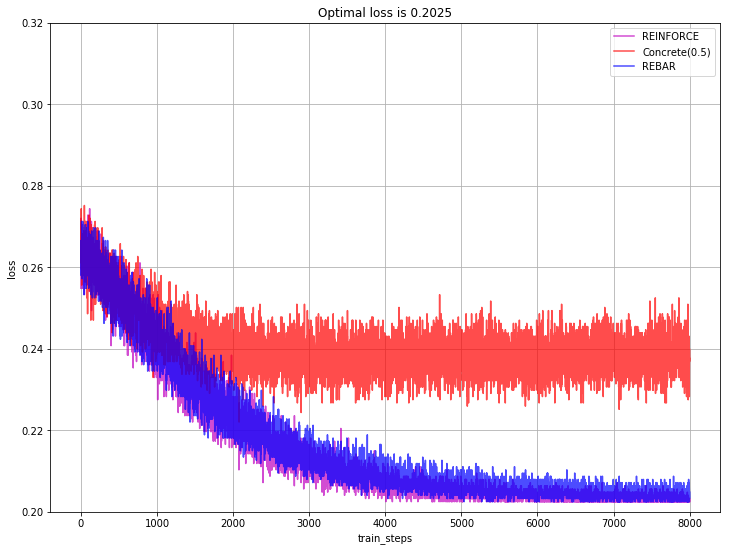

In [6]:
# @hidden_cell
fig = plt.figure(figsize=(12, 9))
plt.plot(reinforce_loss, 'm', label="REINFORCE", alpha=0.7)
plt.plot(concrete_loss, 'r', label="Concrete(0.5)", alpha=0.7)
plt.plot(rebar_loss, 'b', label="REBAR", alpha=0.7)
plt.title("Optimal loss is 0.2025")
plt.xlabel("train_steps")
plt.ylabel("loss")
plt.ylim(0.2, 0.32)
plt.grid(True)
plt.legend()
plt.show()

## Some final thoughts

The variance of the loss in the above plot appears to be significantly greater than in the plots from the paper. Unfortunately, the hyperparameters used for the toy problem were not revealed.. My plot was generated with a batch size of 128. The variance increases a lot with smaller batch sizes. 

It was mentioned in the paper that the scaling factor, $\eta$, can be computed by

$$\frac{\text{Cov}(f,g)}{\text{Var}(g)}.$$

I tried this, but a value of $0.1$ performed better. I may have not been computing $\eta$ correctly though.